In [1]:
%pip install -qU "langchain[openai]"
%pip install -qU langchain-openai
%pip install -qU langchain-chroma
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import getpass

# if the api key doesnt exist get it 
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [44]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma 

llm = init_chat_model("openai:gpt-5-nano")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = Chroma(
    collection_name="qna",
    embedding_function=embeddings
)


In [45]:
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [55]:
from langchain_community.document_loaders import CSVLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = CSVLoader(
    file_path="info.csv",
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [56]:
_ = vector_store.add_documents(all_splits)
print(f"Loaded {len(all_splits)} document chunks")


Loaded 331 document chunks


In [57]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

Conversational experiences can be tracked through messages. Retrieved documents and other artifacts can be retrieved through tool messages. Specifically we will have:

1. User input as **HumanMessage**
2. Vector store query as an **AIMessage** with tool call
3. Retrieved documents as a **ToolMessage**
4. Final response as a **AIMessage**

Tool calling is a way for the AI to interact with not just the user, but also databases and API's. 

In [58]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will have 3 nodes: 

1. A node that fields user input; either generating a query for the retriever or responding directly
2. A node for the retrieval tool that executes the retrieval step
3. A node that generates the final response using the retrieved context

In [59]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"], config={"temperature": 0})
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "If the user asks a question that requires knowledge of the data, "
        "call the `retrieve` tool with the user's query before answering."
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

Finally we create a graph object to connect the steps in the sequence. We also allow **query_or_respond** to respond directly to the user if it does not generate a tool call 

In [60]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node("query_or_respond", query_or_respond)
graph_builder.add_node("tools", tools)
graph_builder.add_node("generate", generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

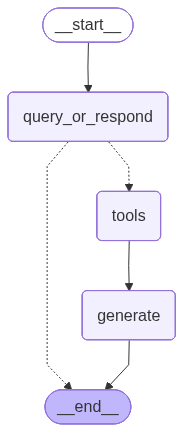

In [61]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
input_message = "Can you give me a description of the company Aica?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you give me a description of the company Aica?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_WcijNHhBOHUGZY7ohV4N9Th1)
 Call ID: call_WcijNHhBOHUGZY7ohV4N9Th1
  Args:
    query: Aica company description
================================= Tool Message =================================
Name: retrieve

Source: {'row': 1, 'source': 'info.csv'}
Content: Company Name: Aica
Domain Name: aica.tech
SwitchPitch Link: https://app.switchpitch.com/startups/262377
Hubspot Link: https://app.hubspot.com/contacts/20173538/company/33626698554
Track: Artificial Intelligence
Website: http://aica.tech
Short Description: Accessible Robotics. For Everyone.
Description: AICA aims to make robotics accessible to all companies. Our technology leverages reinforcement learning (Artificial Intelligence), closed-loop force control, and dynamic motion, giving robots a se

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}